In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [48]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import extract  

In [5]:
#setup the database
engine = create_engine("sqlite:///hawaii.sqlite")
Base = automap_base()


In [6]:
# reflect an existing database into a new model
Base.prepare(engine, reflect=True)

# reflect the tables
Measurement = Base.classes.measurement
Station = Base.classes.station


In [7]:
# We can view all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [8]:
# Save references to each table
Measurement

sqlalchemy.ext.automap.measurement

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Climate Analysis

(array([-500.,    0.,  500., 1000., 1500., 2000., 2500.]),
 <a list of 7 Text xticklabel objects>)

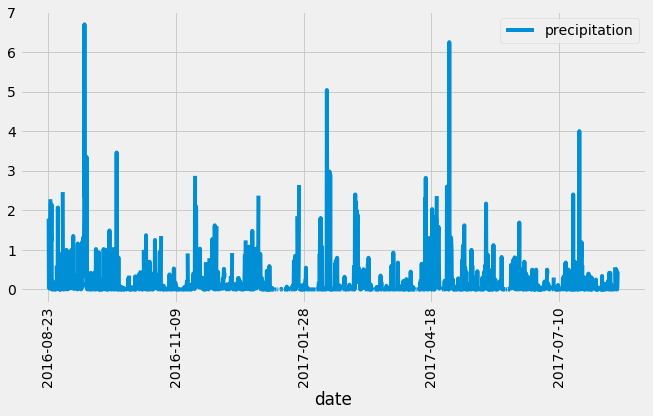

In [19]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
#Starting from the last data point in the database. 

# Calculate the date one year from the last date in data set.
prev_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
results = []
# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= prev_year).all()
#print(results)

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results, columns=['date','precipitation'])
df.set_index(df['date'], inplace=True)

# Sort the dataframe by date
df = df.sort_index()
#print(df.to_string(index=False))

#tick_dates = np.arange(dt.date(2016, 8, 23),dt.date(2017, 8, 23),step=40)

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(figsize=(10,5))
ax = plt.gca()
ax.legend(loc="upper right")

plt.xticks(rotation=90)



In [11]:
df

,date,precipitation
date,,
2016-08-23,2016-08-23,0.00
2016-08-23,2016-08-23,NaN
2016-08-23,2016-08-23,1.79
2016-08-23,2016-08-23,0.05
2016-08-23,2016-08-23,0.15
...,...,...
2017-08-22,2017-08-22,0.00
2017-08-23,2017-08-23,0.00
2017-08-23,2017-08-23,0.00


In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()


,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
# How many stations are available in this dataset?
session.query(func.count(Station.station)).all()

[(9)]

In [14]:
# What are the most active stations?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

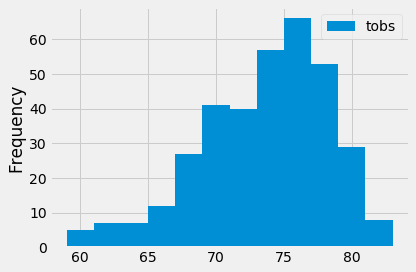

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results = session.query(Measurement.tobs).\
filter(Measurement.station == 'USC00519281').\
filter(Measurement.date >= prev_year).all()

df = pd.DataFrame(results, columns=['tobs'])
#print(df)
df.plot.hist(bins=12)
plt.tight_layout()

In [31]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start=None, end=None):
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]           

    if not end: 
        results = session.query(*sel).\
        filter(Measurement.date <= start).all()
        temps = list(np.ravel(results))
        #return jsonify(temps)
        return temps

    results = session.query(*sel).\
        filter(Measurement.date >= start).\
        filter(Measurement.date <= end).all()
    temps = list(np.ravel(results))
    #return jsonify(temps)
    return temps

# Challenge

In [123]:
#function to determine pull data from analysis
def get_climate(month):

    # Perform a query to retrieve the data and precipitation scores
    results = []
    #extract the month so we can query by month for all years
    results = session.query(Measurement.date, Measurement.prcp, Measurement.tobs ) \
        .filter(extract('month', Measurement.date) == month).all()

    # Save the query results as a Pandas DataFrame and set the index to the date column
    df = pd.DataFrame(results, columns=['date','precipitation', 'temperture'])
    #set index and drop the dupe
    df.set_index(df['date'], inplace=True)
   # df.drop(['date'], axis=1, inplace=True)
    # Sort the dataframe by date
    df = df.sort_index()    
    return df

In [125]:
june_df = get_climate('06')
june_df.describe()

,precipitation,temperture
count,1574.000000,1700.000000
mean,0.136360,74.944118
std,0.335731,3.257417
min,0.000000,64.000000
25%,0.000000,73.000000
50%,0.020000,75.000000
75%,0.120000,77.000000
max,4.430000,85.000000


In [127]:
dec_df = get_climate('12')
dec_df.describe()

,precipitation,temperture
count,1405.000000,1517.000000
mean,0.216819,71.041529
std,0.541399,3.745920
min,0.000000,56.000000
25%,0.000000,69.000000
50%,0.030000,71.000000
75%,0.150000,74.000000
max,6.420000,83.000000


In [ ]:
### further analysis
* turism trends
* local demographics
* statistics on surfing
* 